In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from cvxopt import matrix, solvers
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import timeit
import kagglehub
import nltk
import os
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
import time
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

/Users/minhquang/Documents/MachineLearning/CS115/SupervisedLearning.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/minhquang/Documents/MachineLearning/CS115/SupervisedLearning.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Perceptron Algorithm - PLA

In [2]:
class PLA:
    def __init__(self, X, y, w):
        self.X = X
        self.y = y
        self.w = w
        self.N = X.shape[0]
        
    def distance_measure(self, i):
        numerator = np.abs(np.dot(self.w[1:], self.X[i, :]) + self.w[0])  # Bao gồm bias
        denominator = np.sqrt(self.w[1] ** 2 + self.w[2] ** 2)  # Độ dài vector trọng số
        return numerator / denominator

    def findSupportVectors(self):
        min_pos = float('inf')  # Giá trị nhỏ nhất cho lớp dương
        min_neg = float('inf')  # Giá trị nhỏ nhất cho lớp âm
        idx_pos = None          # Chỉ số vector hỗ trợ cho lớp dương
        idx_neg = None          # Chỉ số vector hỗ trợ cho lớp âm

        for i in range(self.N):
            distance = self.distance_measure(i)
            if self.y[i] == 1 and distance < min_pos:
                min_pos = distance
                idx_pos = i
            elif self.y[i] == -1 and distance < min_neg:
                min_neg = distance
                idx_neg = i
        return idx_pos, idx_neg
                    
    def visualize(self, ax=None):
        scatter = ax.scatter(self.X[:, 0], self.X[:, 1], c=self.y, cmap='bwr', label='Data Points')
        x1 = np.linspace(-5, 5, 1000)
        x2 = -(self.w[0] + self.w[1] * x1) / self.w[2]
        ax.plot(x1, x2, color='green')
        
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
    def sgn(self, i):
        return 1 if np.dot(self.w, np.append([1], self.X[i, :])) >= 0 else -1

    def misclassified_points(self):
        return [i for i in range(self.N) if self.sgn(i) != self.y[i]]

    def pla(self):
        ite = 0
        while True:
            mis_pts = self.misclassified_points()
            if len(mis_pts) == 0:
                break
            i = mis_pts[0]
            self.w += self.y[i] * np.append([1], self.X[i, :])
            ite += 1
            # self.visualize(ite)  # Cập nhật đồ thị
        # plt.ioff()  # Tắt chế độ vẽ tương tác
        # print(f"Training completed in {ite} iterations")

### Visualize Test Data

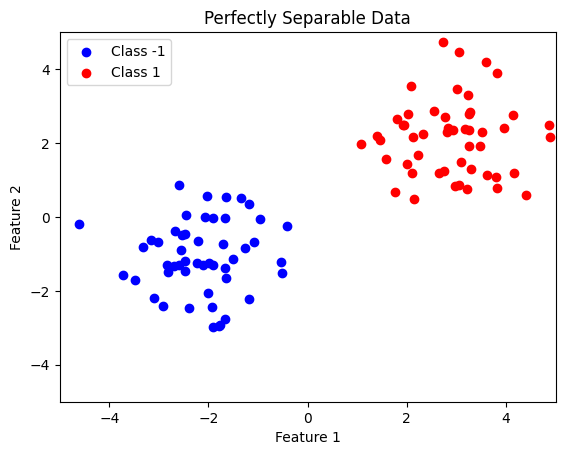

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Đặt seed cố định để tái hiện kết quả
np.random.seed(42)

# Số lượng điểm dữ liệu mỗi lớp
num_points = 50
num_features = 2

# Tạo dữ liệu lớp -1
X_neg = np.random.randn(num_points, num_features) - [2, 1] 
y_neg = -1 * np.ones(num_points)  # Nhãn lớp -1

# Tạo dữ liệu lớp 1
X_pos = np.random.randn(num_points, num_features) + [3, 2] 
y_pos = np.ones(num_points)  # Nhãn lớp 1

# Kết hợp hai lớp dữ liệu
X = np.vstack((X_neg, X_pos))
y = np.hstack((y_neg, y_pos))
w = [0, 1, -1]

# Vẽ biểu đồ scatter
plt.scatter(X_neg[:, 0], X_neg[:, 1], color='blue', label='Class -1')
plt.scatter(X_pos[:, 0], X_pos[:, 1], color='red', label='Class 1')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Perfectly Separable Data')
plt.show()

### Considerations:
- The Hyperplane of PLA is not optimal
- It will change with different w

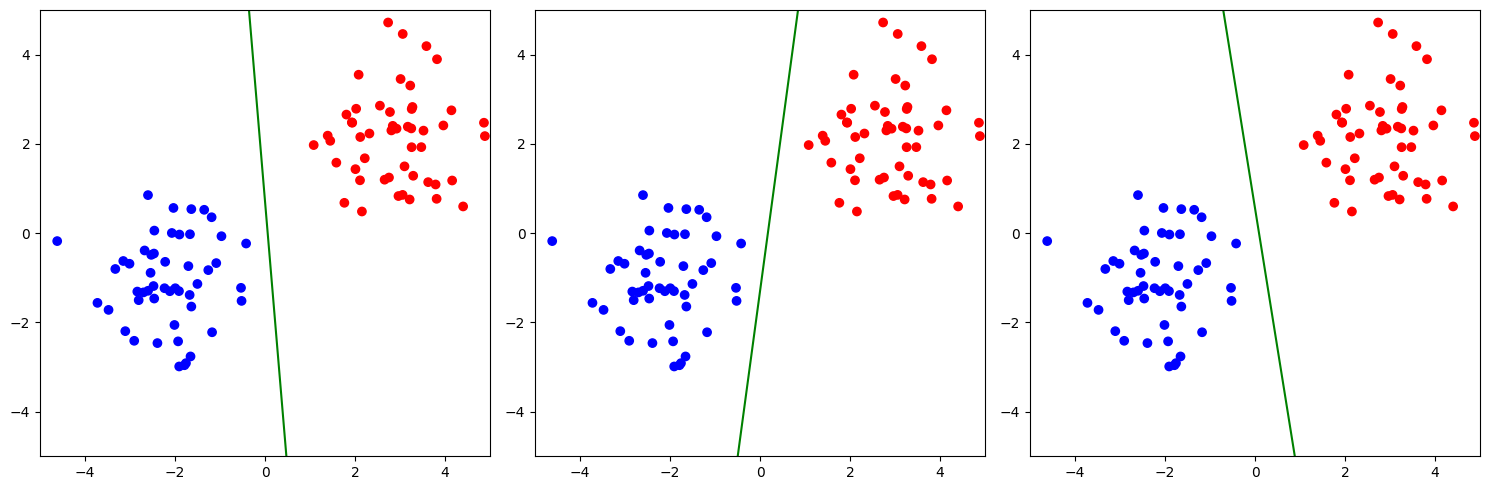

In [4]:
plt.figure(figsize=(15, 5))

for i in range(3):
    w = np.random.rand(3)  
    training = PLA(X, y, w) 
    training.pla() 
    ax = plt.subplot(1, 3, i + 1) 
    training.visualize(ax)  
    

plt.tight_layout()
plt.show()

# Support Vector Machine
### Optimization with Constraints

In [5]:
class SVM:
    # --------- Distance Measure ------------ #
    def __init__(self, X, y, option='soft', C=1):
        y = y.reshape(-1,1)
        '''
        Apply Bias Trick - Hyperplane Equation: y = w.x
        '''
        self.X = X
        self.y = y
        self.w = np.random.rand(X.shape[1])
        self.b = np.random.rand(1)[0]
        self.N = len(y)
        self.C = C
        self.V = (y * X).T
        self.option = option
        self.support_vectors = None
    def norm(self, x, p=1):
        '''
        Default: p = 1
            Specific Case + p = 1 - Manhattan Norm
                        + p = 2 - Euclidean Norm
        '''
        return (np.sum(np.abs(x) ** p) ** (1 / p))

    def classifier(self, x):
        return 1 if self.w @ x + self.b >= 0 else -1
    def find_lamda(self):
        option = self.option
        C = self.C
        '''
        QP Programming:
            Minimize: 1/2 λ^T.(P).λ + (q^T).λ
            Subject to: Gλ <= h, Aλ = b
        Hard Margin:
            Minimize: 1/2 λ^T.(V^T.V).λ - (1^T).λ
            Subject to: -λ <= 0, y^T.λ = 0
        '''
        if option == 'hard':
            V = self.V
            # build object function
            P = matrix((V.T @ V)) # P = V^T.V
            q = matrix(-np.ones(self.N)) # 1^T.λ, q = 1
            # build A, b, G, h
            G = matrix(-np.eye(self.N)) # -λ, G = -I (N x N)
            h = matrix(np.zeros(self.N)) # -λ <= 0, h: 0
            A = matrix(self.y.reshape(1, -1)) # y^T.λ, A = y^T
            b = matrix(np.zeros((1, 1))) # y^T.λ = 0, b = 0
            # Solve QP Programming 
            sol = solvers.qp(P, q, G, h, A, b)
            # Format CVXOPT sol = {'x': matrix([0.5, 0.0, 0.3, 0.2, 0.0])}  
            lamda_opt = np.array(sol['x']).flatten()
            return lamda_opt
        if option == 'soft':
            V = self.V
            # build object function
            P = matrix((V.T @ V))  
            q = matrix(-np.ones(self.N))
            # print('P-size: ', P.size)
            # print('q-size: ', q.size)
            # build constraints
            G1 = -np.eye(self.N)
            G2 = np.eye(self.N) 
            G = np.vstack((G1, G2))
            h1 = np.zeros((self.N, 1))
            h2 = C * np.ones((self.N, 1))
            h = np.concatenate((h1, h2))
            G, h = matrix(G), matrix(h)
            # print('G-size: ', G.size)
            # print('h-size: ', h.size)
            A = matrix(self.y.reshape((-1, self.N)))
            b = matrix(np.zeros((1,1)))
            # print('A-size: ', A.size)
            # print('b-size: ', b.size)
            
            # solve QP
            solvers.options['show_progress'] = False
            sol = solvers.qp(P, q, G, h, A, b)
            lamda_opt = np.array(sol['x']).flatten()
            return lamda_opt        
    def fit(self):
        option = self.option
        C = self.C
        lamda = self.find_lamda()
        epsilon = 1e-4
        S = np.where((lamda > epsilon) & ((lamda <= C) if option == 'soft' else True))[0]
        if len(S) == 0:
            print("No support vectors found!")
            return
        # calculate w and b
        self.w = np.sum((lamda[S].reshape(-1, 1) * self.y[S]) * self.X[S], axis=0)
        self.b = np.mean(self.y[S] - self.X[S] @ self.w.T)
        self.support_vectors = self.X[S]
    def visualize(self):
        option = self.option
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, cmap='autumn')
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # Create grid
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        Z = self.w[0] * XX + self.w[1] * YY + self.b  # Use XX and YY to calculate Z

        # Plot decision boundary and margins
        ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], linestyles=['--', '-', '--'])

        # Plot support vectors
        if self.support_vectors is not None and len(self.support_vectors) > 0:
            plt.scatter(self.support_vectors[:, 0], self.support_vectors[:, 1], s=100,
                        facecolors='none', edgecolors='k', linewidth=1.5)
        plt.xlabel('x1')
        plt.ylabel('x2')
        if option == 'hard':
            plt.title('Hard Margin - SVM - Constraint Optimization') 
        else:
            plt.title('Soft Margin - SVM - Constraint Optimization')
        plt.show()

In [6]:
def loadRandomData(num_points=100, random_seed=42):
    np.random.seed(random_seed)
    num_features = 2
    # Create Data Class -1
    X_neg = np.random.randn(num_points, num_features) - [2, 2] 
    y_neg = -1 * np.ones(num_points)  # Nhãn lớp -1
    # Create Data Class 1
    X_pos = np.random.randn(num_points, num_features) + [2, 2] 
    y_pos = np.ones(num_points)  # Nhãn lớp 1
    # Concatenate data
    X = np.concatenate((X_pos, X_neg), axis=0)
    y = np.hstack((y_pos, y_neg))
    return X, y

     pcost       dcost       gap    pres   dres
 0: -1.8859e+01 -3.9530e+01  7e+02  3e+01  2e+00
 1: -2.8732e+01 -3.1922e+01  4e+02  1e+01  1e+00
 2: -6.4561e+01 -4.4760e+01  3e+02  8e+00  7e-01
 3: -2.0075e+02 -1.1060e+02  3e+02  7e+00  5e-01
 4: -1.3112e+02 -4.7129e+01  2e+02  4e+00  3e-01
 5: -1.6668e+01 -4.9961e+00  4e+01  5e-01  4e-02
 6: -2.7119e+00 -3.9595e+00  1e+00  3e-15  8e-15
 7: -3.4599e+00 -3.4945e+00  3e-02  1e-15  5e-15
 8: -3.4855e+00 -3.4858e+00  3e-04  2e-15  5e-15
 9: -3.4858e+00 -3.4858e+00  3e-06  2e-15  5e-15
Optimal solution found.


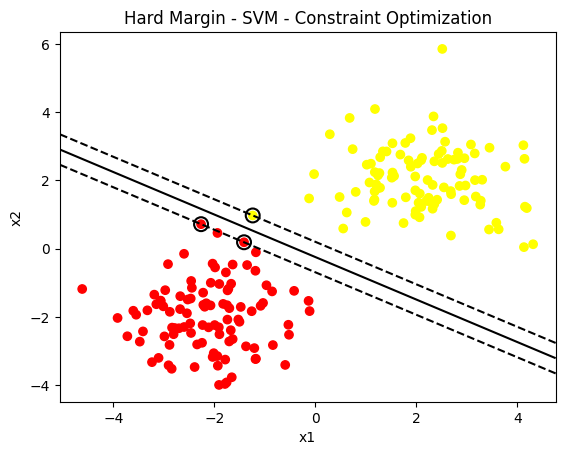

In [7]:
X, y = loadRandomData()
svm = SVM(X, y, option='hard')
svm.fit()
svm.visualize()

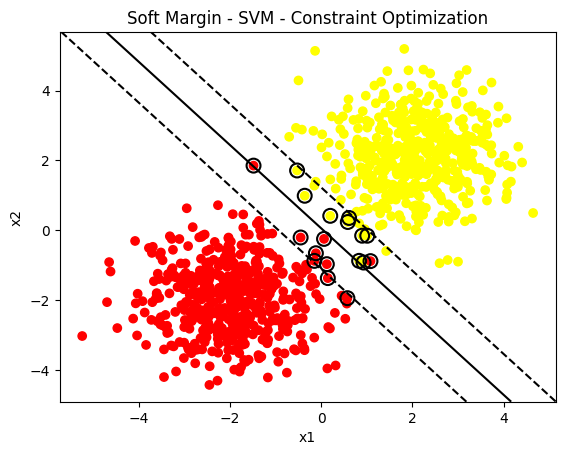

In [8]:
X, y = loadRandomData(num_points=500)
svm = SVM(X, y, option='soft', C=0.2)
excution_time = timeit.timeit('svm.fit()', globals=globals(), number=1)
svm.visualize()

<b><i> => Soft Margin gives a better classification by visual

In [9]:
X, y = loadRandomData(num_points=500)
svm = SVM(X, y, option='soft', C=0.2)
execution_time = timeit.timeit('svm.fit()', globals=globals(), number=1)
print(f"SVM - Constraint Optimization chạy trong: {execution_time:.6f} giây")

SVM - Constraint Optimization chạy trong: 2.429041 giây


<b><i> => Soft Margin can resolve non-perfect linear seperable data

In [10]:
X, y = loadRandomData(num_points=500)
y = y.ravel()
clf = SVC(C=0.2, kernel='linear')  # C is the regularization parameter for the soft margin
sklearn_time = timeit.timeit('clf.fit(X, y)', globals=globals(), number=1)
w = clf.coef_[0]
b = clf.intercept_[0]
print(f"Sklearn - SVM chạy trong: {sklearn_time:.6f} giây")

Sklearn - SVM chạy trong: 0.139891 giây


<b><i> => Soft Margin With Constraint Optimization is so long <br> </b></i>
Solutions:
# Solving this with No-Constraint Optimization

In [2]:
class softSVM:
    def __init__(self, C):
        '''
        C: trade-off parameter between margin and loss
        '''
        self.C = C
        self.lamda = 1/C
        self.X = None
        self.y = None
        self.w = None
        self.b = None
        self.support_vectors = None
        self.n = 0 # number of data points
        self.d = 0 # number of features
    def decision_function(self, X):
        return X @ self.w + self.b
    def cost(self, X):
        return 0.5 * (self.w.T @ self.w) + self.C * np.mean(np.maximum(0, 1 - self.y * self.decision_function(X)))
    def find_support_vectors(self, X):
        sv_idx = np.where((self.y * self.decision_function(X)) < 1)[0]
        return sv_idx
    def mini_batch_gradient_descent(self, sv_idx, batch_size=64):
        '''
        Use for large-scale data
        '''
        if len(sv_idx) == 0:
            return np.zeros_like(self.w), 0
        # Lấy ngẫu nhiên một batch con từ các SV
        batch_size = min(batch_size, len(sv_idx))
        batch_idx = np.random.choice(sv_idx, batch_size)
        d_w = self.lamda * self.w - (self.C * (self.y[batch_idx] @ self.X[batch_idx])).T
        d_b = -self.C * np.mean(self.y[batch_idx])
        return d_w, d_b
    def gradient_descent(self, sv_idx):
        if len(sv_idx) == 0:
            return np.zeros_like(self.w), 0
        d_w = self.lamda * self.w - (self.C * (self.y[sv_idx] @ self.X[sv_idx])).T
        d_b = -self.C * np.mean(self.y[sv_idx])
        return d_w, d_b
    def fit(self, X, y, schedule='step',lr=1e-3, epochs=1000, decay_rate=0.9, step_size=100):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.w = np.random.rand(self.d)
        self.b = 0
        cost_values = []
        for epoch in range(epochs):
            # Learning Rate Scheduling: accelarate the converge progress
            if schedule == 'step' and epoch % step_size == 0:
                lr *= decay_rate
            elif schedule == 'exponential':
                lr = lr * np.exp(-decay_rate * epoch)
            elif schedule == 'time-based':
                lr = lr / (1 + decay_rate * epoch)
            sv_idx = self.find_support_vectors(X)
            d_w, d_b = self.mini_batch_gradient_descent(sv_idx)
            self.w -= lr * d_w
            self.b -= lr * d_b
            if epoch % 100 == 0:
                cost = self.cost(X)
                cost_values.append(cost)
            if np.linalg.norm(d_w) < 1e-4 or (len(cost_values) > 1 and np.abs(cost_values[-1] - cost_values[-2]) < 1e-4):
                print(f'Converged at epoch {epoch}')
                break
    def predict(self, X):
        return np.sign(self.decision_function(X))
    def score(self, X, y):
        predict_labels = self.predict(X)
        return np.mean(y == predict_labels)
    def visualize(self):
        self.support_vectors = self.find_support_vectors(X)
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, marker='o', cmap='autumn')
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        # create grid
        xx = np.linspace(xlim[0], xlim[1], 30) 
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = self.decision_function(xy).reshape(XX.shape)
        
        # plot decision boundary and margins
        ax.contour(XX, YY, Z, colors=['g', 'k', 'g'], levels=[-1, 0, 1], linestyles=['--', '-', '--'])
        # highlight sv
        ax.scatter(self.X[self.support_vectors, 0], self.X[self.support_vectors, 1], s=80, facecolors='none', edgecolors='k', linewidth=1)
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.show()

In [84]:
# Optimize with Mini-Batch Gradient Descent, Learning Rate Scheduling
X, y = loadRandomData(num_points=100000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
svm = softSVM(C=0.2)
execution_time = timeit.timeit('svm.fit(X_train, y_train, lr=1e-3 ,epochs=10000)', globals=globals(), number=1)
accuracy = svm.score(X_test, y_test)
print('Accuracy:', accuracy)
print(f"SVM - No-Constraint Optimization chạy trong: {execution_time:.6f} giây")

Converged at epoch 1500
Accuracy: 0.99705
SVM - No-Constraint Optimization chạy trong: 1.104230 giây


In [85]:
# sk-learn Soft Margin
X, y = loadRandomData(num_points=100000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = SVC(C=0.2, kernel='linear')  # C is the regularization parameter for the soft margin
sklearn_time = timeit.timeit('clf.fit(X, y)', globals=globals(), number=1)
sk_accuracy = clf.score(X_test, y_test)
print('Accuracy:', sk_accuracy)
print(f"Sklearn - SVM chạy trong: {sklearn_time:.6f} giây")

Accuracy: 0.997
Sklearn - SVM chạy trong: 5.625840 giây


# Apply Spam or Ham Email Classification

In [86]:
#========================== Pre-proccessing Data ==========================#
#------------ clean text ---------------#   
def clean_whitespace(text):
    return ' '.join(text.split())
    
def remove_punctuations(text):
    return re.sub(r'[^\w\s]', '', text)
def remove_numbers(text):
    return re.sub(r'\d+', '', text)
def clean_text(text):
    '''
    Ways:
        + remove punctuation
        + remove number
        + clean extra whitespace
        + lower text
    '''
    if not isinstance(text, str) or not text.strip():
        return ""
    text = remove_punctuations(text)
    text = remove_numbers(text)
    text = clean_whitespace(text)
    text = text.lower()
    return text
#------------ tokenize ---------------#
def tokenize(text):
    return text.split()
#------------ remove stopwords ---------------#
def remove_stopwords(tokens):
    return [token for token in tokens if token not in ENGLISH_STOP_WORDS]
#------------ TF-IDF ---------------#
def TF(tokens, token):
    '''
    tokens: total words
    token: word
    formula: TF = freq(token) / len(tokens)
    '''
    count = sum(1 for ele in tokens if ele == token)
    return count / len(tokens)
def IDF(X, token):
    '''
    X: total rows
    token: word
    formula: IDF = log(len(X) / (rows has token))
    '''
    count = sum(1 for x in X if token in set(x))
    if count == 0:
        return 0
    return np.log(len(X) / count) 
def TF_IDF(X, x, token):
    '''
    X: Total corpus (list of documents)
    x: Document to calculate TF for
    token: Word to calculate TF-IDF
    Formula: TF-IDF = TF * IDF
    '''
    return float(TF(x, token) * IDF(X, token))

#------------- Main pre-proccessing ---------------#
def preproccessing_spam_email(X):
    cleaned_X = [' '.join(remove_stopwords(tokenize(clean_text(doc[0])))) for doc in X]
    vectorizer = TfidfVectorizer()
    vectorized_X = vectorizer.fit_transform(cleaned_X).toarray()
    return vectorized_X
#========================== Pre-proccessing Data ==========================#

In [ ]:
def load_email_data():
    # Kaggle: spam_ham_email dataset
    path = kagglehub.dataset_download("venky73/spam-mails-dataset")
    print("Path to dataset files:", path)
    files = os.listdir(path)
    data_file = os.path.join(path, 'spam_ham_dataset.csv')
    data = pd.read_csv(data_file)
    '''
    take data for pre-proprocessing
        + take features (col 2) for X, label for y (col 3)
    ''' 
    X = data.iloc[:, 2]
    y = data.iloc[:, 3]
    X = np.array([X]).T
    y = np.array(y).T
    y = np.where(y == 0, -1, 1)
    return X, y

In [ ]:
def preprocessing_data(X):
    start_time = time.time()
    X = preproccessing_spam_email(X)
    X = normalize(X, norm='l2')
    preprocessing_time = time.time() - start_time
    print(f'Preprocessing Time: {preprocessing_time:.6f} seconds' )
    return X

In [92]:
def find_optimal_C_lr():
    '''
    Find optimal trade-off paramater C and learning rate
    '''
    # Hyperparameters for Grid Search
    C_values = [0.1, 1, 10, 100]
    lr_values = [0.01, 0.1, 0.5]
    k = 5

    # Cross-Validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    best_score = -1
    best_params = None
    
    for C in C_values:
        for lr in lr_values:
            scores = []
            for train_idx, test_idx in kf.split(X):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]
                
                model = softSVM(C)
                model.fit(X_train, y_train, lr=lr, epochs=1000)
                score = model.score(X_test, y_test)
                scores.append(score)
            
            avg_score = np.mean(scores)
            print(f"C={C}, lr={lr}, Average Score={avg_score}")
            
            if avg_score > best_score:
                best_score = avg_score
                best_params = {'C': C, 'lr': lr}
    
    print(f"Best parameters: {best_params}, Best Score: {best_score}")
    return best_params

In [93]:
find_optimal_C_lr()

Path to dataset files: /Users/minhquang/.cache/kagglehub/datasets/venky73/spam-mails-dataset/versions/1
Preprocessing Time: 5.084865 seconds
Number of Points: 5171
Number of Dimensions: 45474
Number of Labels: 2
Converged at epoch 600
C=0.1, lr=0.01, Average Score=0.7101127837113037
Converged at epoch 800
Converged at epoch 900
Converged at epoch 700
C=0.1, lr=0.1, Average Score=0.7101127837113037


/var/folders/70/d3kd_ryx2t11f9844q1jv12w0000gn/T/ipykernel_25179/105453470.py:18: RuntimeWarning: overflow encountered in matmul
  return 0.5 * (self.w.T @ self.w) + self.C * np.mean(np.maximum(0, 1 - self.y * self.decision_function(X)))
/var/folders/70/d3kd_ryx2t11f9844q1jv12w0000gn/T/ipykernel_25179/105453470.py:58: RuntimeWarning: invalid value encountered in scalar subtract
  if np.linalg.norm(d_w) < 1e-4 or (len(cost_values) > 1 and np.abs(cost_values[-1] - cost_values[-2]) < 1e-4):


C=0.1, lr=0.5, Average Score=0.2898872162886964
C=1, lr=0.01, Average Score=0.8559244620114186
C=1, lr=0.1, Average Score=0.8837716667133874
C=1, lr=0.5, Average Score=0.907174800736318
Converged at epoch 100
Converged at epoch 93
Converged at epoch 91
Converged at epoch 95
Converged at epoch 95
C=10, lr=0.01, Average Score=0.9793070389370111
Converged at epoch 22
Converged at epoch 25
Converged at epoch 22
Converged at epoch 29
Converged at epoch 23
C=10, lr=0.1, Average Score=0.9849152019734813
Converged at epoch 501
Converged at epoch 203
Converged at epoch 446
Converged at epoch 301
Converged at epoch 316
C=10, lr=0.5, Average Score=0.9765996692176155
Converged at epoch 19
Converged at epoch 26
Converged at epoch 23
Converged at epoch 24
Converged at epoch 22
C=100, lr=0.01, Average Score=0.9837546603874078
Converged at epoch 17
Converged at epoch 20
Converged at epoch 18
Converged at epoch 18
Converged at epoch 18
C=100, lr=0.1, Average Score=0.9806604434726542
Converged at epoch 

In [96]:
def main():
    # prepare data
    X, y = load_email_data()
    X = preprocessing_data(X)
    print('Number of Points:', X.shape[0])
    print('Number of Dimensions:', X.shape[1])
    print('Number of Labels: 2')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # find optimal C, learning-rate
    C, lr = find_optimal_C_lr()
    # train data
    svm = softSVM(C = C)
    start_time = time.time()
    svm.fit(X_train, y_train, lr=lr, epochs=1000, decay_rate=0.9, step_size=100)
    train_time = time.time() - start_time

    # Evaluate Model
    accuracy = svm.score(X_test, y_test)
    print('Accuracy:', accuracy)
    print(f"Training time: {train_time:.6f} seconds")

Accuracy: 0.993475
Training time: 0.612069 seconds


In [76]:
# sk-learn linear SVC
clf = LinearSVC(C=100, max_iter=1000)
start_time = time.time()
clf.fit(X_train, y_train)
sklearn_time = time.time() - start_time
accuracy_sklearn = clf.score(X_test, y_test)
print(f"Sklearn LinearSVC Accuracy: {accuracy_sklearn}")
print(f"Sklearn Training time: {sklearn_time:.6f} seconds")

Sklearn LinearSVC Accuracy: 0.996975
Sklearn Training time: 0.100983 seconds


In [77]:
# sk-learn SVC
clf = SVC(C=100, kernel='linear')
start_time = time.time()
clf.fit(X_train, y_train)
sklearn_time = time.time() - start_time
accuracy_sklearn = clf.score(X_test, y_test)
print(f"Sklearn LinearSVC Accuracy: {accuracy_sklearn}")
print(f"Sklearn Training time: {sklearn_time:.6f} seconds")

Sklearn LinearSVC Accuracy: 0.997
Sklearn Training time: 8.742564 seconds


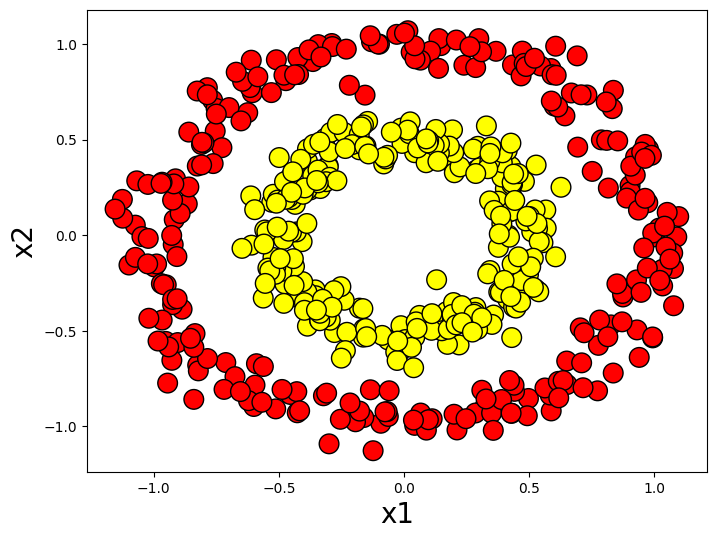

In [6]:
from sklearn.datasets import make_circles
X, y = make_circles(500, factor=.5, noise=.08)
y[y ==0 ] = -1
plt.figure(figsize = (8,6))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=200, edgecolor='k', cmap='autumn')
plt.xlabel('x1', fontsize=20)
plt.ylabel('x2', fontsize=20)
plt.show()

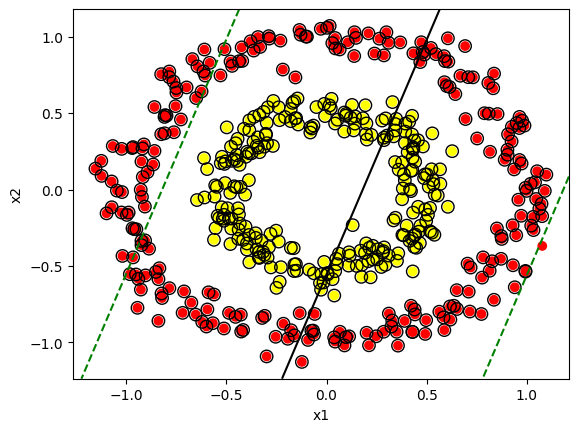

In [10]:
svm = softSVM(C=1)
svm.fit(X, y, schedule='step', lr=0.1, epochs=500, decay_rate=0.9, step_size=50)
svm.visualize()


=> Can't apply Soft Margin for Non-Linear Seperable Data